# Load the dataset

In [79]:
import pandas as pd

df = pd.read_csv('dataset.csv')

# Inspect the data

In [80]:
print(df.head())
print(df.info())
print(df.isnull().sum())

                                     CRASH_RECORD_ID     RD_NO  \
0  012c5bfce715efb2f2b387d6dd86f9c13e9dc1809fb52a...  JG341943   
1  01d457f032e23d935a0b8f6b4c88221375180ffd4cd959...  JG338388   
2  02249b4747a4bf40b88a8357304a98dfeaef9c38eebbf0...  JG350008   
3  03e3b6caad71b78ed9ae325648effa9512bfb2517aed30...  JG338049   
4  0481fc919b38f1572d4ba04b069766102d904a662ff096...  JG338431   

  CRASH_DATE_EST_I              CRASH_DATE  POSTED_SPEED_LIMIT  \
0              NaN  07/12/2023 03:05:00 PM                  30   
1              NaN  07/12/2023 05:50:00 PM                  30   
2              NaN  07/12/2023 02:00:00 PM                  30   
3              NaN  07/12/2023 07:05:00 AM                  30   
4              NaN  07/12/2023 06:30:00 PM                  30   

  TRAFFIC_CONTROL_DEVICE DEVICE_CONDITION      WEATHER_CONDITION  \
0            NO CONTROLS      NO CONTROLS                  CLEAR   
1            NO CONTROLS      NO CONTROLS                  CLEAR   
2 

#  Fill missing values with zero

In [81]:
df_filled = df.fillna(0)

In [82]:
df = df.dropna(subset=['LATITUDE', 'LONGITUDE'])

In [83]:
# Filter out invalid latitude and longitude values
df = df[(df['LATITUDE'] != 0) & (df['LONGITUDE'] != 0)]

In [84]:
# Check for duplicate coordinates
duplicates = df[df.duplicated(subset=['LATITUDE', 'LONGITUDE'], keep=False)]
print("Duplicates:")
print(duplicates)

Duplicates:
                                          CRASH_RECORD_ID     RD_NO  \
0       012c5bfce715efb2f2b387d6dd86f9c13e9dc1809fb52a...  JG341943   
1       01d457f032e23d935a0b8f6b4c88221375180ffd4cd959...  JG338388   
3       03e3b6caad71b78ed9ae325648effa9512bfb2517aed30...  JG338049   
4       0481fc919b38f1572d4ba04b069766102d904a662ff096...  JG338431   
5       0500576055e3d46b0ed507761bfeae64457b1b58871f42...  JF345041   
...                                                   ...       ...   
746491  fffd23633eee1547f4c617afed5a22dc5bdc763f1283b2...  JD232641   
746493  fffd677d6dc42284b0120f213770fce9e112dee8c01534...  HZ566267   
746494  fffa0699ec25d473a27cb465f36cee8ae8ced41b517ed6...  JC163902   
746495  fff1f7b29389052e517be1418da4e8164e9d84a14bf384...  JB276732   
746496  ffe608f479def7f47768f7287f1431a9af5056668611d8...  JF216876   

       CRASH_DATE_EST_I              CRASH_DATE  POSTED_SPEED_LIMIT  \
0                   NaN  07/12/2023 03:05:00 PM                 

# Geospatial Analysis

In [85]:
# Convert the pandas DataFrame to a GeoDataFrame.
import geopandas as gpd
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Load a map of Chicago

In [86]:
chicago_map = gpd.read_file('Boundaries - Community Areas (current)')

<Axes: >

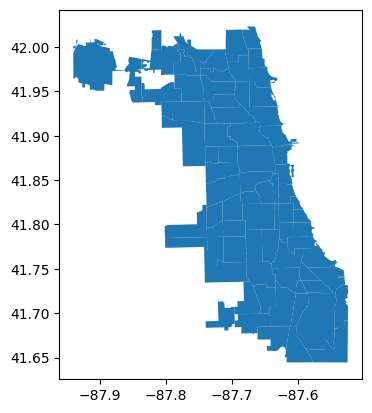

In [87]:
chicago_map.plot()

# Visualize Hotspots

In [88]:
# Aggregate data by location and street name
location_counts = gdf.groupby(['LATITUDE', 'LONGITUDE', 'STREET_NAME']).size().reset_index(name='counts')

In [153]:
# Get the top 10 hotspots
top_50_hotspots = location_counts.nlargest(50, 'counts')

In [90]:
# Create a GeoDataFrame for the top 10 hotspots
top_50_geometry = [Point(xy) for xy in zip(top_50_hotspots['LONGITUDE'], top_50_hotspots['LATITUDE'])]
top_50_gdf = gpd.GeoDataFrame(top_50_hotspots, geometry=top_50_geometry)

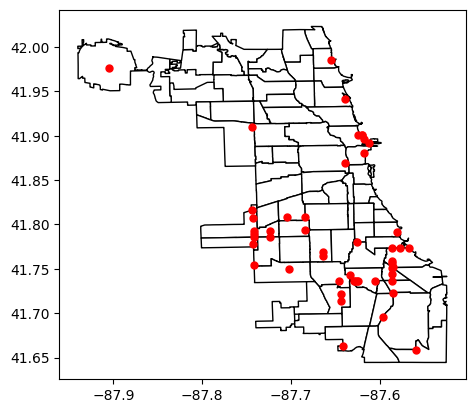

In [165]:
# Highlight the top 10 hotspots with larger markers
import matplotlib.pyplot as plt
# Plotting with larger figure size
base = chicago_map.plot(color='white', edgecolor='black')
top_50_gdf.plot(ax=base, marker='o', color='red', markersize=25)
plt.show()

In [92]:
print(location_counts.columns)


Index(['LATITUDE', 'LONGITUDE', 'STREET_NAME', 'counts'], dtype='object')


In [154]:
# Print the top 50 hotspots to verify
print("Top 50 Hotspots:")
print(top_50_hotspots)

Top 50 Hotspots:
         LATITUDE  LONGITUDE        STREET_NAME  counts
260423  41.976201 -87.905309           OHARE ST    1187
79804   41.791420 -87.580148      LAKE SHORE DR     538
41272   41.751461 -87.585972   STONY ISLAND AVE     521
21308   41.722257 -87.585276   STONY ISLAND AVE     411
177887  41.900959 -87.619928   LAKE SHORE DR SB     392
43994   41.754660 -87.741385         CICERO AVE     356
177886  41.900959 -87.619928   LAKE SHORE DR NB     290
78226   41.789329 -87.741646         CICERO AVE     289
177668  41.900753 -87.624235      LAKE SHORE DR     272
28254   41.736209 -87.624306           STATE ST     266
17762   41.714119 -87.643145         HALSTED ST     249
28448   41.736380 -87.627509            87TH ST     233
28202   41.736165 -87.625588      LAFAYETTE AVE     231
29023   41.736823 -87.585783   STONY ISLAND AVE     225
67499   41.778335 -87.742436         CICERO AVE     221
62395   41.773439 -87.566899     SOUTH SHORE DR     219
81431   41.792911 -87.742077   

# Heatmap with Folium

In [94]:
import folium
from folium.plugins import HeatMap
from IPython.display import IFrame
import pandas as pd

In [95]:
import folium
from folium.plugins import HeatMap
from IPython.display import IFrame

# Get the top 50 hotspots
top_50_hotspots = location_counts.nlargest(50, 'counts')

# Create a map centered around Chicago
m = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

# Create a heatmap layer
heat_data = [[row['LATITUDE'], row['LONGITUDE']] for index, row in top_50_hotspots.iterrows()]

# Custom gradient to show only red color
gradient = {0.2: 'red', 0.4: 'red', 0.6: 'red', 0.8: 'red', 1.0: 'red'}

# Add the heatmap layer with the custom gradient
HeatMap(heat_data, gradient=gradient).add_to(m)

# Add markers with street names
for index, row in top_50_hotspots.iterrows():
    folium.Marker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        popup=row['STREET_NAME'],
        icon=folium.Icon(color='red')
    ).add_to(m)

# Save the map
map_file = 'chicago_accident_heatmap_with_street_names.html'
m.save(map_file)

# Display the map in the Jupyter Notebook
IFrame(map_file, width=800, height=600)


# Cluster Analysis

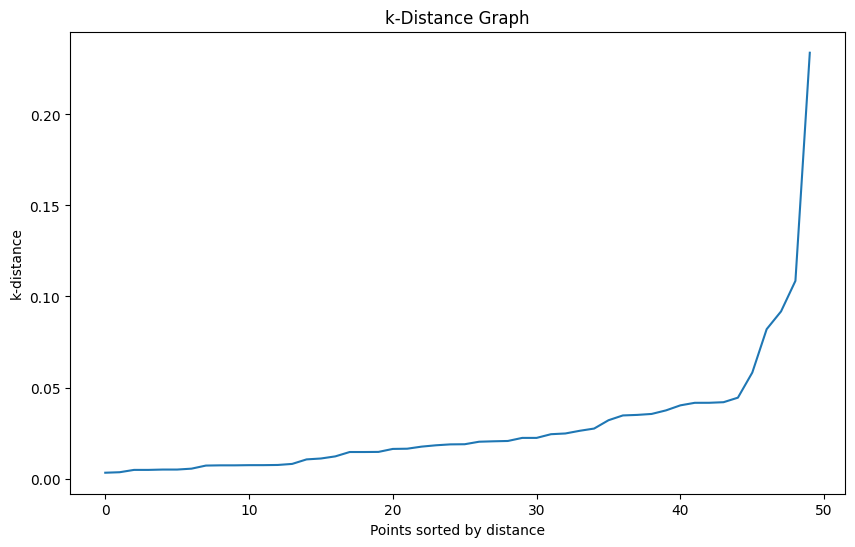

In [102]:
from sklearn.neighbors import NearestNeighbors
# Extract coordinates
coords = top_50_hotspots[['LATITUDE', 'LONGITUDE']].values

# Compute k-distance graph for k = min_samples
k = 4  # You can experiment with different values of k
nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(coords)
distances, indices = neighbors.kneighbors(coords)

# Sort distances to plot k-distance graph
distances = np.sort(distances[:, k-1], axis=0)
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance')
plt.title('k-Distance Graph')
plt.show()

In [189]:
# # DBSCAN Clustering
# from sklearn.cluster import DBSCAN
# import numpy as np
# # Downsample the data to a manageable size
# # sampled_df = df.sample(n=700000, random_state=42) 
# # Extract coordinates
# coords = top_50_hotspots[['LATITUDE', 'LONGITUDE']].values
# db = DBSCAN(eps=0.01, min_samples=10).fit(coords)
# labels = db.labels_
# # Add cluster labels to the top 50 hotspots dataframe
# top_50_hotspots['cluster'] = labels

from sklearn.cluster import DBSCAN
import numpy as np

coords = top_50_hotspots[['LATITUDE', 'LONGITUDE']].values
db = DBSCAN(eps=0.05, min_samples=4).fit(coords)
labels = db.labels_

top_50_hotspots['cluster'] = labels


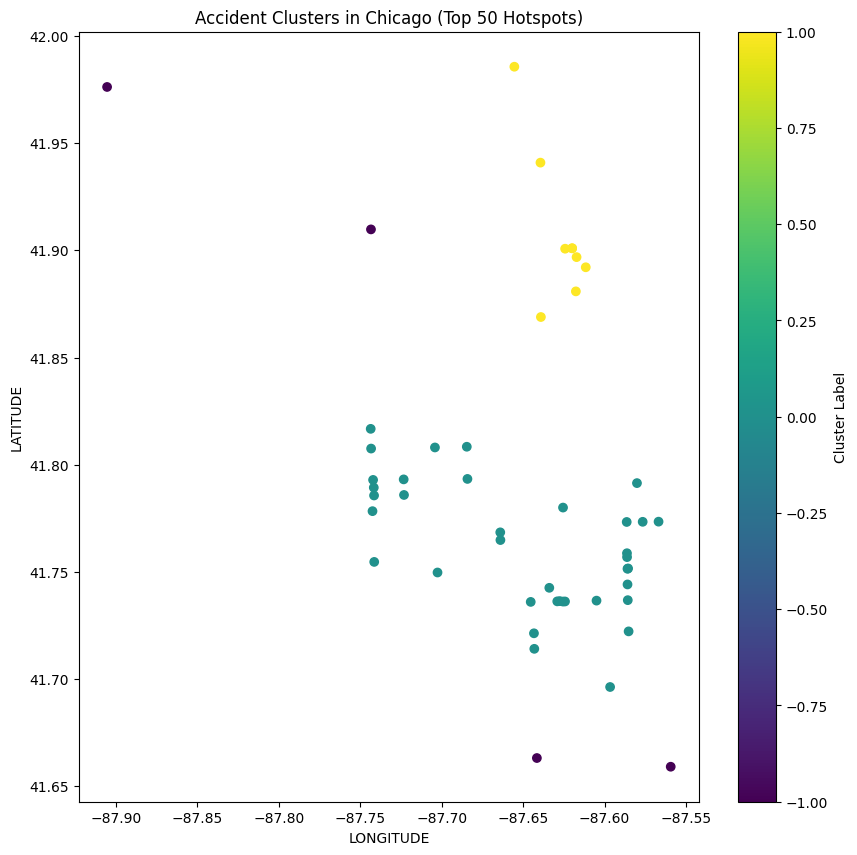

In [190]:
# Plotting clusters
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.scatter(top_50_hotspots['LONGITUDE'], top_50_hotspots['LATITUDE'], c=top_50_hotspots['cluster'], cmap='viridis', marker='o')
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.title('Accident Clusters in Chicago (Top 50 Hotspots)')
plt.colorbar(label='Cluster Label')
plt.show()

# Analyze cluster characteristics

In [191]:
top_50_hotspots['cluster'] = labels
print(top_50_hotspots.head(50))

         LATITUDE  LONGITUDE        STREET_NAME  counts  cluster
260423  41.976201 -87.905309           OHARE ST    1187       -1
79804   41.791420 -87.580148      LAKE SHORE DR     538        0
41272   41.751461 -87.585972   STONY ISLAND AVE     521        0
21308   41.722257 -87.585276   STONY ISLAND AVE     411        0
177887  41.900959 -87.619928   LAKE SHORE DR SB     392        1
43994   41.754660 -87.741385         CICERO AVE     356        0
177886  41.900959 -87.619928   LAKE SHORE DR NB     290        1
78226   41.789329 -87.741646         CICERO AVE     289        0
177668  41.900753 -87.624235      LAKE SHORE DR     272        1
28254   41.736209 -87.624306           STATE ST     266        0
17762   41.714119 -87.643145         HALSTED ST     249        0
28448   41.736380 -87.627509            87TH ST     233        0
28202   41.736165 -87.625588      LAFAYETTE AVE     231        0
29023   41.736823 -87.585783   STONY ISLAND AVE     225        0
67499   41.778335 -87.742

In [193]:
# Cluster analysis with additional details
cluster_summary = top_50_hotspots.groupby('cluster').agg({
    'counts': 'count',
    'STREET_NAME': lambda x: x.value_counts().idxmax(),  # Most common street in each cluster
}).rename(columns={'counts': 'Total Roads',
                   'STREET_NAME': 'Most accidents '})

print(cluster_summary)

         Total Roads Most accidents 
cluster                             
-1                 4        OHARE ST
 0                37      CICERO AVE
 1                 9   LAKE SHORE DR
